<AxesSubplot:>

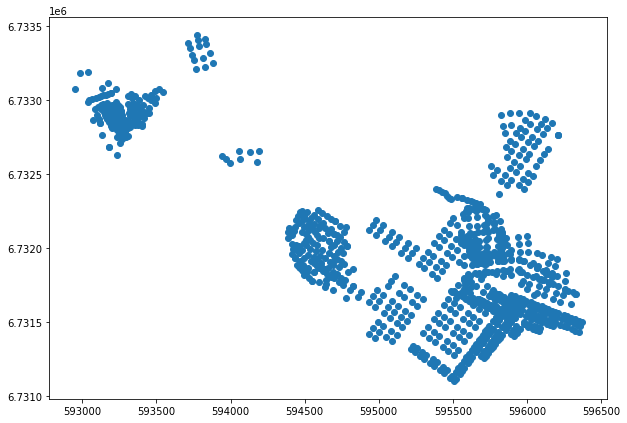

In [90]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()
data_dir = Path('../data/processed')
data = gpd.read_file(data_dir / 'spatial_income_1880.gpkg').dropna()

data.plot(figsize=(10,10))

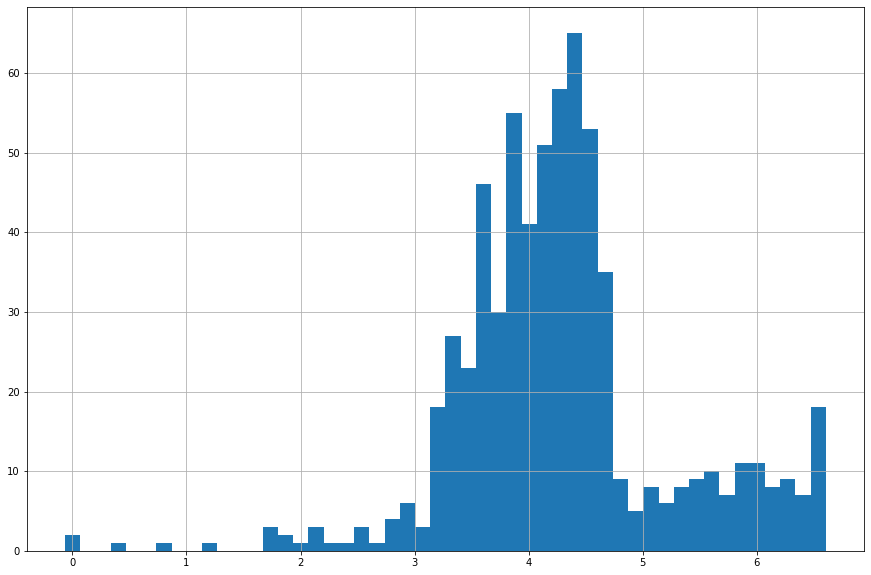

array([[<AxesSubplot:title={'center':'lutheran'}>]], dtype=object)

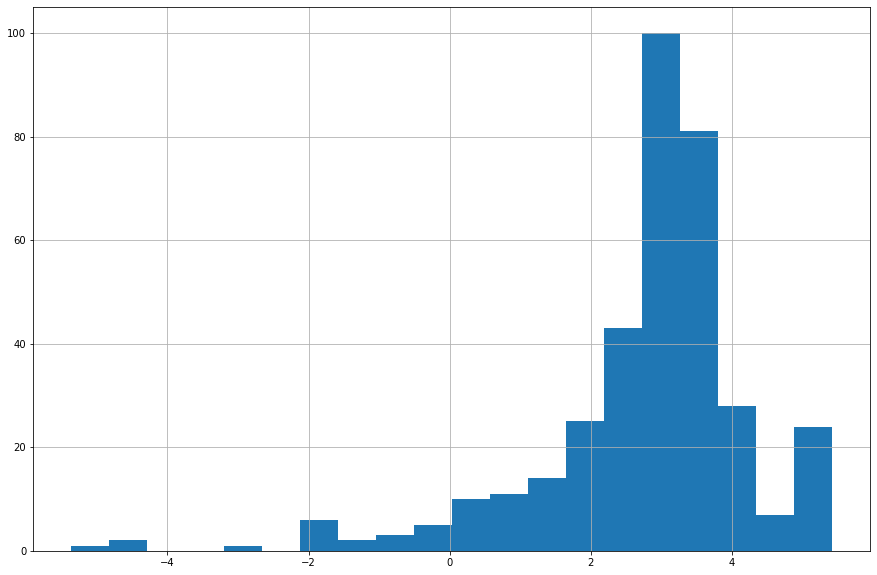

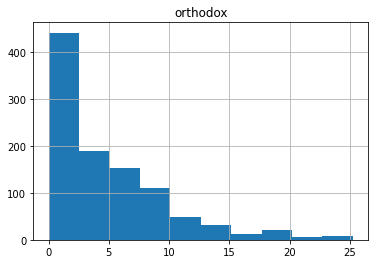

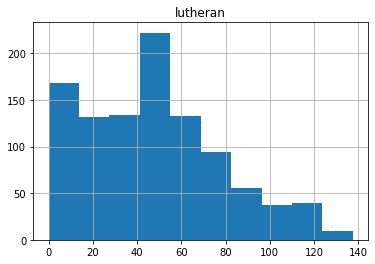

In [91]:
data.loc[data.is_old,'total_income_ln'].hist(figsize=(15,10), bins=50)
plt.show()
data.loc[~data.is_old,'total_income_ln'].hist(figsize=(15,10), bins=20)
data.hist(column='orthodox')
data.hist(column='lutheran')
# data.iplot(x='total_income', y='total_density', kind='scatter', mode='markers')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_L, beta_O, sigma, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


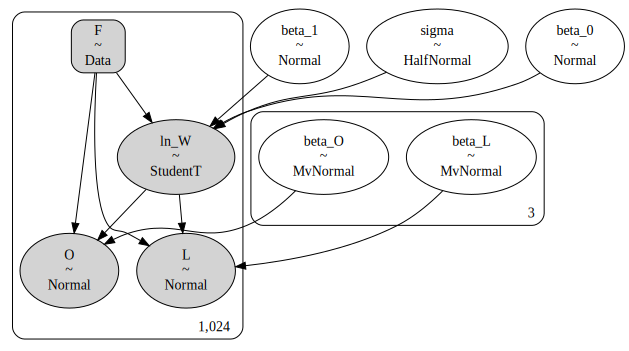

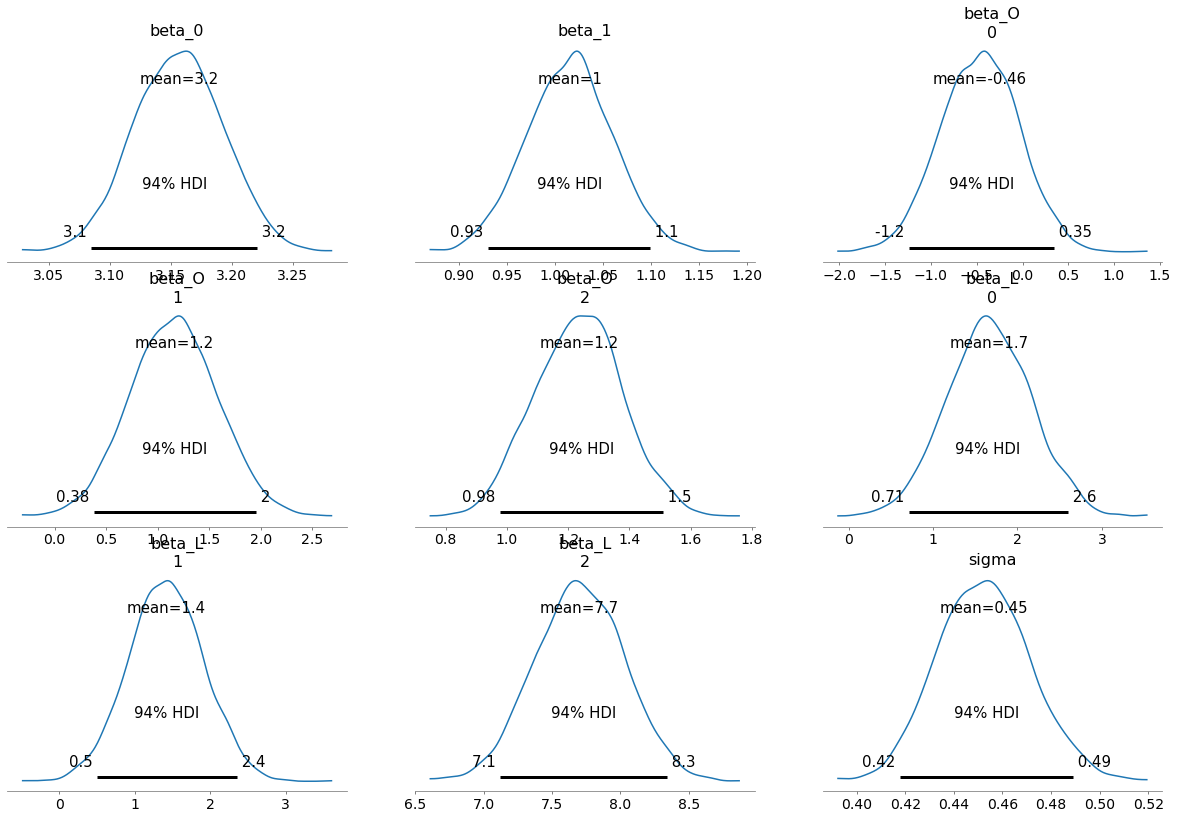

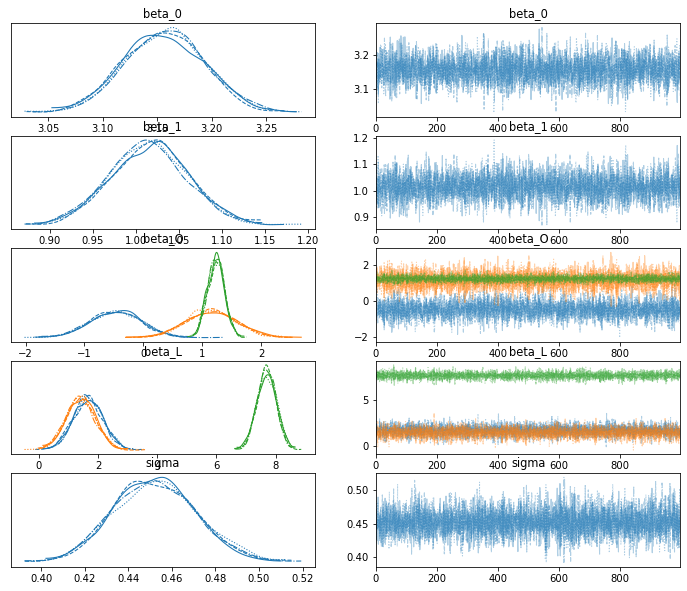

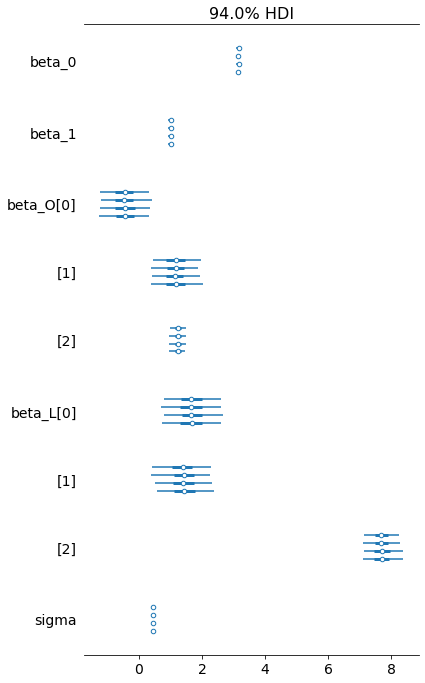

In [92]:
with pm.Model() as model_1:
    F = pm.Data('F', data.is_old.astype('int'))
    beta_0 = pm.Normal('beta_0', mu=4, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    ln_W = pm.StudentT('ln_W', nu=1, mu=beta_0 + beta_1 * F, sigma=sigma, observed=data.total_income_ln)

    mu_beta_O = np.array([0., 0., 0.])
    mu_beta_L = np.array([0., 0., 0.])
    sigma_beta_O = np.array(np.diagflat([0.25, 0.25, 0.25]))
    sigma_beta_L = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O = pm.MvNormal('beta_O', mu_beta_O, sigma_beta_O, shape=3)
    beta_L = pm.MvNormal('beta_L', mu_beta_L, sigma_beta_L, shape=3)
    # O_mu = pm.Deterministic('O_mu', beta_O[0] + beta_O[1] * F + beta_O[2] * ln_W)
    # L_mu = pm.Deterministic('L_mu', beta_L[0] + beta_L[1] * F + beta_L[2] * ln_W)
    sigma_O = 10
    sigma_L = 50

    O = pm.Normal('O', beta_O[0] + beta_O[1] * F + beta_O[2] * ln_W, sigma_O, observed=data.orthodox)
    L = pm.Normal('L', beta_L[0] + beta_L[1] * F + beta_L[2] * ln_W, sigma_L, observed=data.lutheran)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_1)